In [50]:
import phik
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from warnings import filterwarnings
filterwarnings("ignore")

# Задача
В датасете находится информация о флаге и базовых показателях страны. На основе доступной информации решается задача классификации стран по религии. 

In [36]:
# Features
features_names = [
    "name", "landmass", "zone", "area", "population", 
    "language", "religion", "bars", "stripes", "colours", 
    "red", "green", "blue", "gold", "white", 
    "black", "orange", "mainhue", "circles", "crosses", 
    "saltires", "quarters", "sunstars", "crescent", "triangle", 
    "icon", "animate", "text", "topleft", "botright"
]
# DataFrame
flags_df = pd.read_csv("flag.data", )
flags_df.columns = columns=features_names
flags_df = flags_df.drop(columns="name")   # название страны не поможет в построении обобщающей модели
flags_df["label"] = flags_df["religion"] 
flags_df.drop(columns="religion", inplace=True)
flags_df.head()

,landmass,zone,area,population,language,bars,stripes,colours,red,green,...,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright,label
0,3,1,29,3,6,0,0,3,1,0,...,0,1,0,0,0,1,0,red,red,6
1,4,1,2388,20,8,2,0,3,1,1,...,0,1,1,0,0,0,0,green,white,2
2,6,3,0,0,1,0,0,5,1,0,...,0,0,0,1,1,1,0,blue,red,1
3,3,1,0,0,6,3,0,3,1,0,...,0,0,0,0,0,0,0,blue,red,0
4,4,2,1247,7,10,0,2,3,1,0,...,0,1,0,0,1,0,0,red,black,5


# EDA

In [37]:
print(f"Количество строк: {flags_df.shape[0]}, фич: {flags_df.shape[1]}")

Количество строк: 193, фич: 29


In [38]:
print(f"Пропущенных значений в датасете: {sum(flags_df.isna().sum().to_list())}")

Пропущенных значений в датасете: 0


### Виден явный дизбаланс классов меток

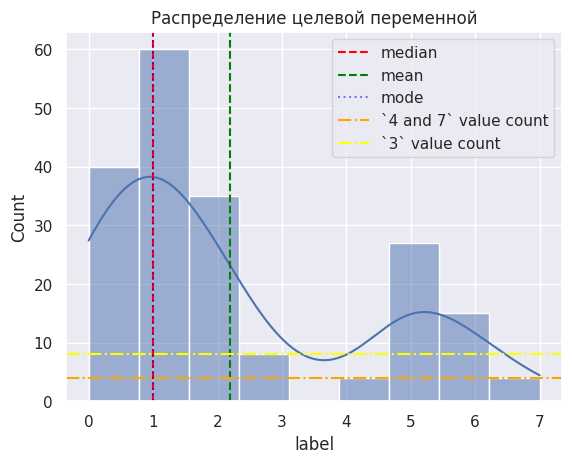

In [39]:
sns.set_theme()
sns.histplot(flags_df["label"], kde=True,).set_title("Распределение целевой переменной")
plt.axvline(flags_df["label"].quantile(0.5), label="median", color="red", linestyle="--")
plt.axvline(flags_df["label"].mean(), label="mean", color="green", linestyle="--")
plt.axvline(flags_df["label"].mode().to_list()[0], label="mode", color="blue", alpha=0.5, linestyle=":")
plt.axhline(flags_df.query("label==4")["label"].count(), linestyle="-.", color="orange", label="`4 and 7` value count")
plt.axhline(flags_df.query("label==3")["label"].count(), linestyle="-.", color="yellow", label="`3` value count")
plt.xticks(range(0, 8, 1))
plt.legend()
plt.show()

In [40]:
flags_df.groupby("label")["label"].count()

label
0    40
1    60
2    35
3     8
4     4
5    27
6    15
7     4
Name: label, dtype: int64

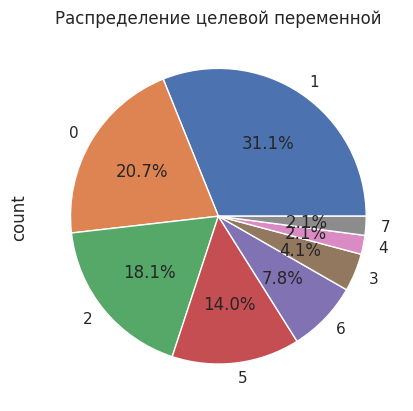

In [88]:
plt.title("Распределение целевой переменной")
flags_df["label"].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [41]:
flags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   landmass    193 non-null    int64 
 1   zone        193 non-null    int64 
 2   area        193 non-null    int64 
 3   population  193 non-null    int64 
 4   language    193 non-null    int64 
 5   bars        193 non-null    int64 
 6   stripes     193 non-null    int64 
 7   colours     193 non-null    int64 
 8   red         193 non-null    int64 
 9   green       193 non-null    int64 
 10  blue        193 non-null    int64 
 11  gold        193 non-null    int64 
 12  white       193 non-null    int64 
 13  black       193 non-null    int64 
 14  orange      193 non-null    int64 
 15  mainhue     193 non-null    object
 16  circles     193 non-null    int64 
 17  crosses     193 non-null    int64 
 18  saltires    193 non-null    int64 
 19  quarters    193 non-null    int64 
 20  sunstars  

# Тестовое обучение на неизмененных данных

In [42]:
test = flags_df.copy()
test = pd.get_dummies(test)
test.head()

,landmass,zone,area,population,language,bars,stripes,colours,red,green,...,topleft_red,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white
0,3,1,29,3,6,0,0,3,1,0,...,True,False,False,False,False,False,False,False,True,False
1,4,1,2388,20,8,2,0,3,1,1,...,False,False,False,False,False,False,False,False,False,True
2,6,3,0,0,1,0,0,5,1,0,...,False,False,False,False,False,False,False,False,True,False
3,3,1,0,0,6,3,0,3,1,0,...,False,False,False,False,False,False,False,False,True,False
4,4,2,1247,7,10,0,2,3,1,0,...,True,False,True,False,False,False,False,False,False,False


In [43]:
print(f"Количество строк: {test.shape[0]}, фич: {test.shape[1]}")

Количество строк: 193, фич: 49


In [44]:
def get_classifier_report(X, y, test_size=0.2, model=None,):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0) 
    model = model
    model.fit(X_train, y_train)
    print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))

In [46]:
get_classifier_report(
    X=test[list(test.drop(columns="label"))],
    y=test["label"],
    test_size=0.2,
    model=RandomForestClassifier(random_state=0, max_samples=0.67, max_features=3, n_estimators=1000, max_depth=10)
)

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.87      1.00      0.93        13
           2       0.80      0.67      0.73         6
           4       0.00      0.00      0.00         1
           5       0.67      0.80      0.73         5
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         1

    accuracy                           0.79        39
   macro avg       0.58      0.53      0.53        39
weighted avg       0.77      0.79      0.76        39



In [47]:
test.shape

(193, 49)

### Матрица корреляций категориальных признаков

interval columns not set, guessing: ['landmass', 'zone', 'area', 'population', 'language', 'bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'circles', 'crosses', 'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text', 'label']


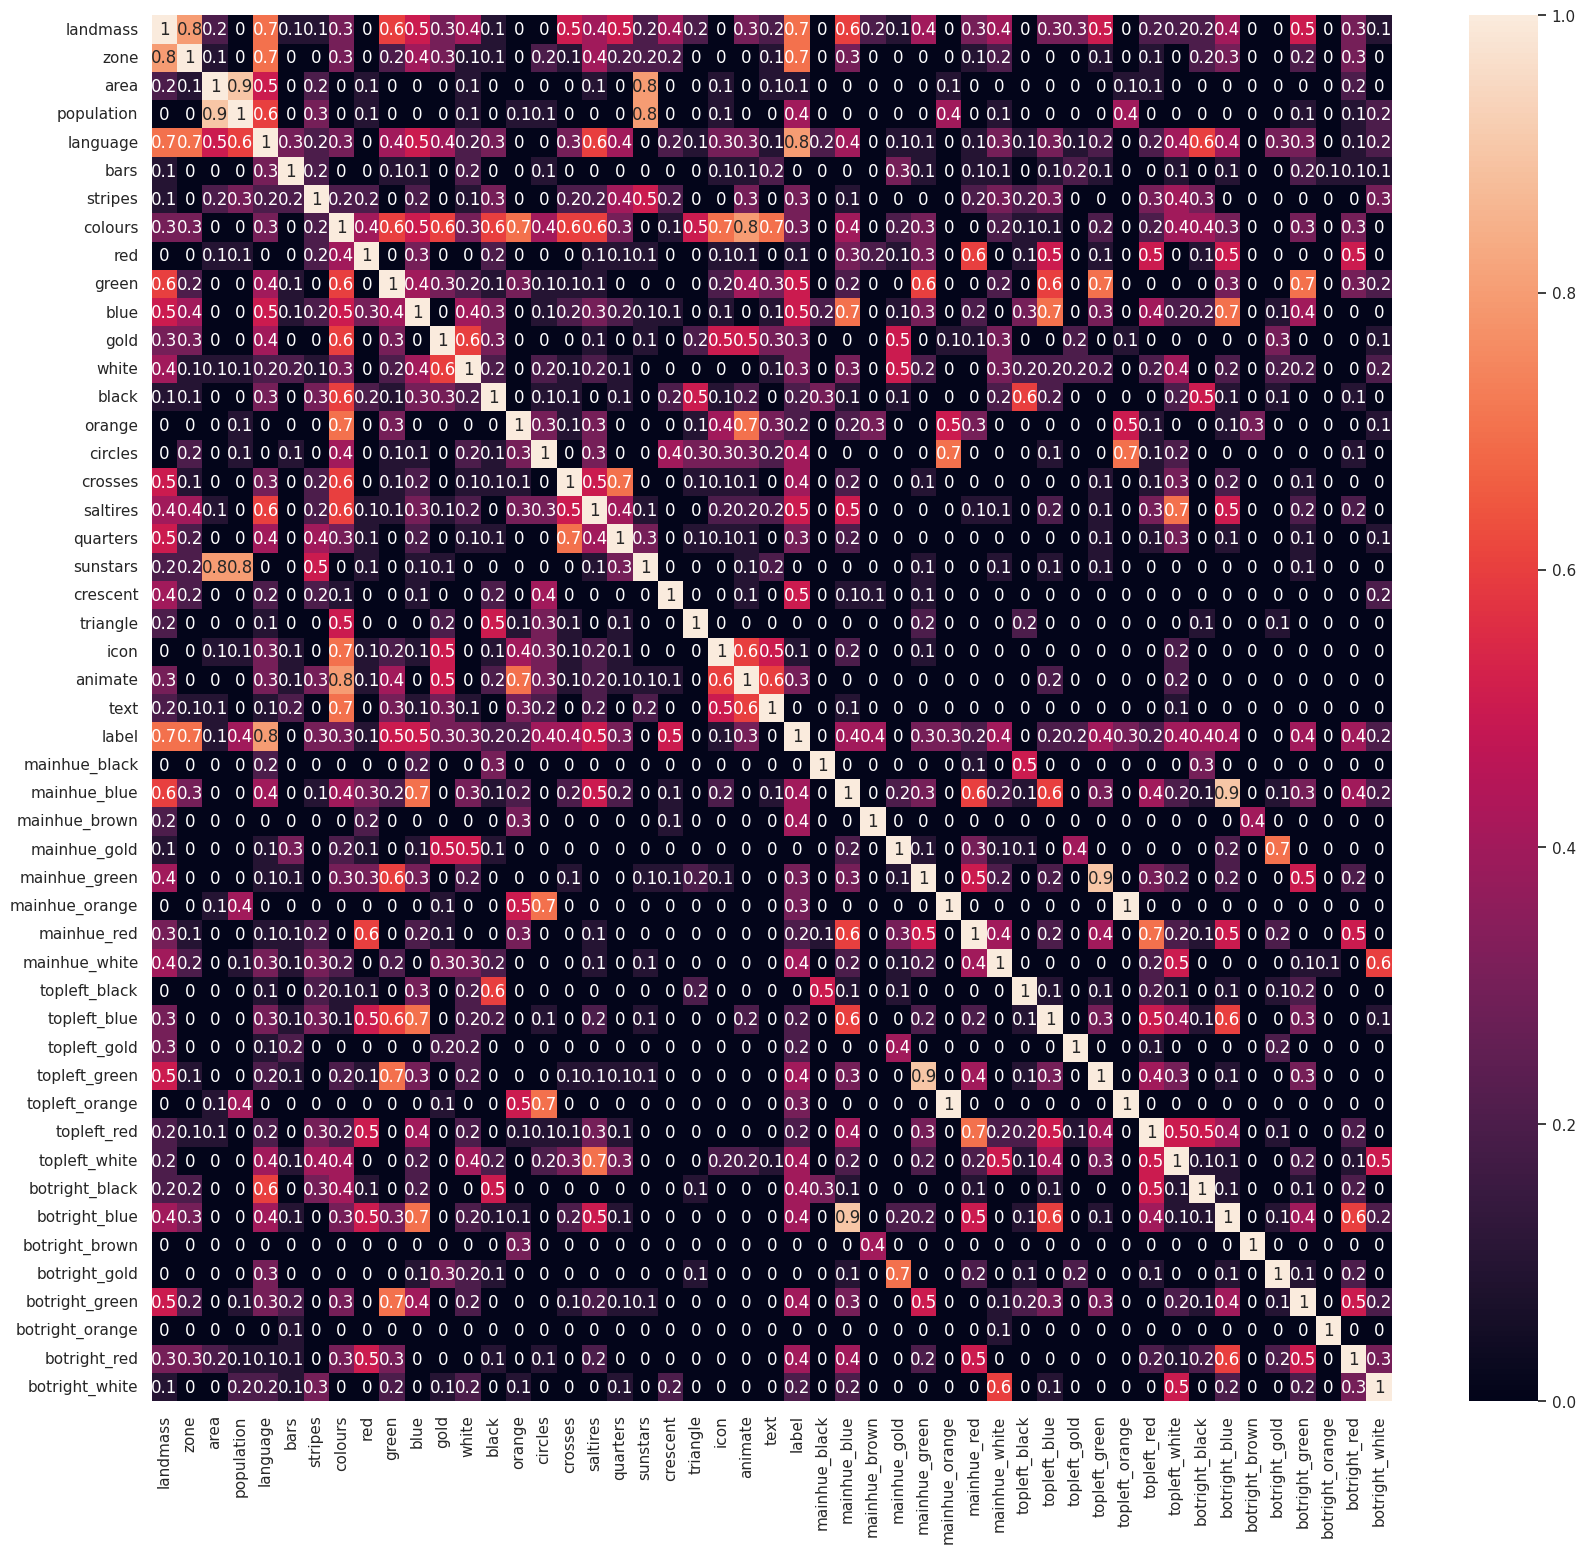

In [60]:
plt.figure(figsize=(20, 18))
sns.heatmap(test.phik_matrix().round(1), annot=True)
plt.show()

### Подбор фич и нормализация

In [54]:
new_model = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(random_state=0, max_samples=0.67, max_features=3, n_estimators=1000, max_depth=10))

In [52]:
sfs = SequentialFeatureSelector(new_model, n_features_to_select=10, cv=5, n_jobs=-1)
# sfs.fit(test[list(test.drop(columns="label"))], test["label"])
# sfs.get_feature_names_out()
# ['landmass', 'population', 'language', 'circles', 'crosses', 'quarters', 'crescent', 'mainhue_white', 'topleft_white', 'botright_blue']

['landmass', 'population', 'language', 'circles', 'crosses', 'quarters', 'crescent', 'mainhue_white', 'topleft_white', 'botright_blue']


<Figure size 2000x1600 with 0 Axes>

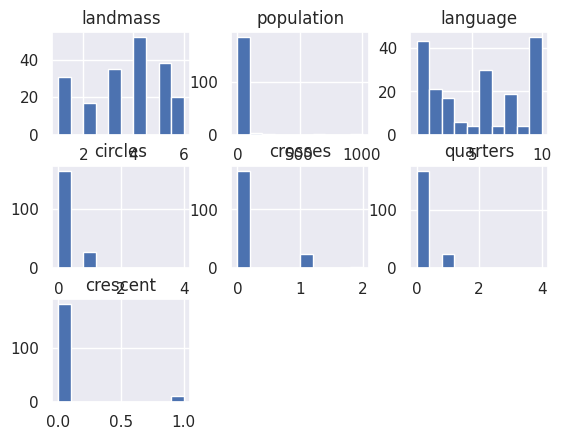

In [63]:
plt.figure(figsize=(20, 16))
test[['landmass', 'population', 'language', 'circles', 'crosses', 'quarters', 'crescent', 'mainhue_white', 'topleft_white', 'botright_blue']].hist()
plt.show()

<Figure size 1600x1400 with 0 Axes>

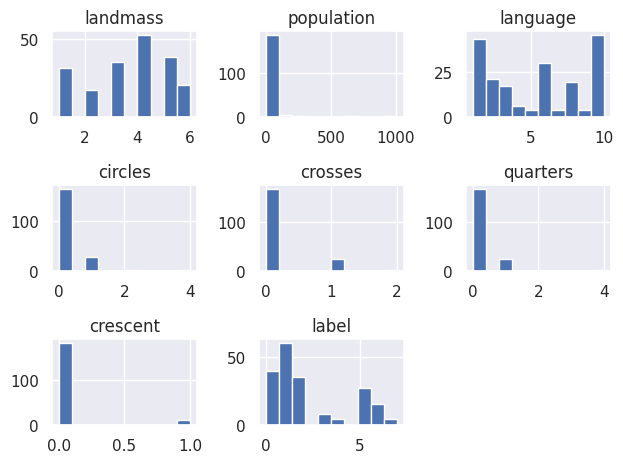

In [66]:
plt.figure(figsize=(16, 14))
test[['landmass', 'population', 'language', 'circles', 'crosses', 'quarters', 'crescent', 'mainhue_white', 'topleft_white', 'botright_blue', 'label']].hist()
plt.tight_layout()
plt.show()

In [84]:
get_classifier_report(
    X=test[['landmass', 'population', 'language', 'circles', 'crosses', 'quarters', 'crescent', 'mainhue_white', 'topleft_white', 'botright_blue']],
    y=test["label"],
    model=new_model,
    test_size=0.24
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       0.67      1.00      0.80         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       1.00      0.83      0.91         6
           6       1.00      0.75      0.86         4
           7       0.00      0.00      0.00         2

    accuracy                           0.89        47
   macro avg       0.58      0.57      0.57        47
weighted avg       0.88      0.89      0.88        47



### Предсказание 0, 1, 2, 5, 6 метки класса очень улучшилась, учитывая что я только отобрал признаки и нормализовал данные 

In [67]:
# 3 4 7
test.query("label==3")

,landmass,zone,area,population,language,bars,stripes,colours,red,green,...,topleft_red,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white
19,5,1,47,1,10,0,0,4,1,0,...,False,False,False,False,False,False,False,False,True,False
27,5,1,678,35,10,0,0,3,1,0,...,False,False,False,False,False,False,False,False,True,False
77,5,1,1,5,7,0,0,6,1,1,...,False,True,False,True,False,False,False,False,False,False
91,5,1,181,6,10,0,0,2,1,0,...,True,False,False,False,False,False,False,False,True,False
149,5,1,1,3,7,0,2,2,1,0,...,True,False,False,False,False,False,False,False,False,True
156,5,1,66,15,10,2,0,4,0,1,...,False,False,False,False,False,True,False,False,False,False
167,5,1,36,18,7,0,0,3,1,0,...,False,False,False,False,False,False,False,False,True,False
169,5,1,514,49,10,0,5,3,1,0,...,True,False,False,False,False,False,False,False,True,False


In [83]:
descr = test.query("label==3").describe().loc[['mean', '50%', 'std', 'min', 'max']]
descr.head()

,landmass,zone,area,population,language,bars,stripes,colours,red,green,...,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,label
mean,5.0,1.0,190.50000,16.500000,8.875000,0.250000,0.875000,3.37500,0.875000,0.25000,...,0.125000,0.125000,0.375000,2.500000,0.125000,0.0,0.500000,0.500000,0.125000,3.0
50%,5.0,1.0,56.50000,10.500000,10.000000,0.000000,0.000000,3.00000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.500000,0.000000,3.0
std,0.0,0.0,260.26964,17.188036,1.552648,0.707107,1.807722,1.30247,0.353553,0.46291,...,0.353553,0.353553,0.517549,4.956958,0.353553,0.0,0.534522,0.534522,0.353553,0.0
min,5.0,1.0,1.00000,1.000000,7.000000,0.000000,0.000000,2.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.0
max,5.0,1.0,678.00000,49.000000,10.000000,2.000000,5.000000,6.00000,1.000000,1.00000,...,1.000000,1.000000,1.000000,14.000000,1.000000,0.0,1.000000,1.000000,1.000000,3.0
